In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

load and check sample data 

In [3]:
n_rois = 68
count_offset = 100
data_path = 'sample_data/abcd_data.npy'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path)
n_subs = brain_networks.shape[0]
print(brain_networks.shape)
print(traits.shape)
print(translations.shape)
print(avg_trans.shape)

(8646, 4624)
(8646, 12)
(8646, 6)
(8646, 1)


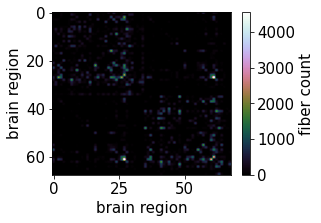

In [4]:
# check brain adjacency matrix

plt.figure(figsize=(4, 3))
plt.imshow(brain_networks.mean(0).reshape(n_rois, n_rois)*count_offset, aspect='auto', cmap='cubehelix')
plt.xlabel('brain region')
plt.ylabel('brain region')
plt.colorbar(label='fiber count')
plt.show()

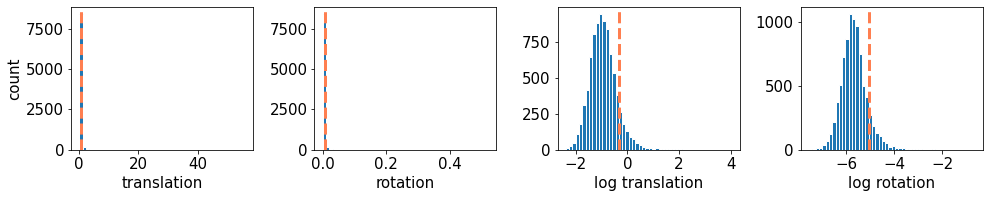

In [16]:
# check motion and rescale motion
# original scale is not ideal so use log transformation

log_trans = np.log(avg_trans)
log_rotat = np.log(avg_rotat)
motion = np.concatenate([log_trans, log_rotat], axis=-1)

fig, axes = plt.subplots(1,4,figsize=(14,3))
axes[0].hist(avg_trans, 50, edgecolor='white')
axes[0].axvline(x=np.quantile(avg_trans, .9), color='coral', ls='dashed', lw=3)
axes[0].set_xlabel('translation')
axes[0].set_ylabel('count')
axes[1].hist(avg_rotat, 50, edgecolor='white')
axes[1].axvline(x=np.quantile(avg_rotat, .9), color='coral', ls='dashed', lw=3)
axes[1].set_xlabel('rotation')
axes[2].hist(std_trans, 50, edgecolor='white')
axes[2].axvline(x=np.quantile(log_trans, .9), color='coral', ls='dashed', lw=3)
axes[2].set_xlabel('log translation')
axes[3].hist(std_rotat, 50, edgecolor='white')
axes[3].axvline(x=np.quantile(log_rotat, .9), color='coral', ls='dashed', lw=3)
axes[3].set_xlabel('log rotation')
plt.tight_layout()
plt.show()

In [17]:
# mark subjects with big motion for later analysis

sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_trans_ids = sub_ids[std_trans > np.quantile(std_trans, .9)]
big_rotat_ids = sub_ids[std_rotat > np.quantile(std_rotat, .9)]
big_motion_ids = np.union1d(big_trans_ids, big_rotat_ids)
big_motion_mask = np.zeros_like(sub_ids)
big_motion_mask[np.isin(sub_ids, big_motion_ids)] = True
print('num of big motion subjects: {}.'.format(len(big_motion_ids)))

small_trans_ids = sub_ids[std_trans < np.quantile(std_trans, .1)]
small_rotat_ids = sub_ids[std_rotat < np.quantile(std_rotat, .1)]
small_motion_ids = np.union1d(small_trans_ids, small_rotat_ids)
small_motion_mask = np.zeros_like(sub_ids)
small_motion_mask[np.isin(sub_ids, small_motion_ids)] = True
print('num of small motion subjects: {}.'.format(len(small_motion_ids)))

num of big motion subjects: 1058.
num of small motion subjects: 1341.


model fitting

In [32]:
# model config

config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    alpha = 1, beta = .01, gamma = 1, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=100, lr=1e-5, device=DEVICE)

In [33]:
# prepare torch datasets for training

ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits[:,4]).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

958 107


In [34]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

5 torch.Size([68, 68])


vae

In [35]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [ ]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 9484.826 nll: -656.573 kl: 436.365 rmse: 17.792
epoch: 0 test loss: 2653.359 nll: -5928.117 kl: 819.239 rmse: 17.583
epoch: 5 train loss: -16339.834 nll: -16809.489 kl: 16486.153 rmse: 3.069
epoch: 5 test loss: -16567.023 nll: -17018.741 kl: 17302.033 rmse: 3.205
epoch: 10 train loss: -16426.695 nll: -16883.459 kl: 16509.643 rmse: 3.002
epoch: 10 test loss: -16637.117 nll: -17079.469 kl: 16783.807 rmse: 3.181
epoch: 15 train loss: -16453.705 nll: -16902.271 kl: 16056.710 rmse: 2.983
epoch: 15 test loss: -16662.017 nll: -17096.227 kl: 16346.270 rmse: 3.158
epoch: 20 train loss: -16468.695 nll: -16909.556 kl: 15708.250 rmse: 2.961
epoch: 20 test loss: -16676.510 nll: -17103.106 kl: 16013.669 rmse: 3.132
epoch: 25 train loss: -16479.482 nll: -16912.990 kl: 15439.760 rmse: 2.936
epoch: 25 test loss: -16686.820 nll: -17106.287 kl: 15761.884 rmse: 3.103
epoch: 30 train loss: -16488.640 nll: -16914.757 kl: 15222.971 rmse: 2.909
epoch: 30 test loss: -16695.562 nll: -17108.

In [ ]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [ ]:
# torch.save(model.state_dict(), './pretrained/hcp_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/hcp_vae_pretrained.mod'))

In [ ]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [ ]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_recon = x_recon[big_motion_ids]
small_motion_recon = x_recon[small_motion_ids]
diff_motion_recon= big_motion_recon.mean(0) - small_motion_recon.mean(0)

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_recon.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('recon count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
# to do - add viz for recon, motion correction and trait prediction, etc.



inv-vae

In [87]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    alpha = 1.1, beta = 1., gamma = .1, add_reg = True, y_dim = 1,
    # alpha = 1.1, beta = .1, gamma = .1, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=200, lr=1e-6, device=DEVICE)

In [88]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [89]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 18469.930 nll: 6246.467 kl: 213.838 inv_loss: 5.011 rmse: 18.874
epoch: 0 test loss 16713.127 nll: 4970.718 kl: 205.832 inv_loss: 6.891 rmse: 20.006
epoch: 5 train loss: 6301.058 nll: -3424.938 kl: 290.194 inv_loss: 5.489 rmse: 17.490
epoch: 5 test loss 5014.208 nll: -4303.299 kl: 322.184 inv_loss: 7.336 rmse: 18.486
epoch: 10 train loss: -1891.014 nll: -9720.467 kl: 643.850 inv_loss: 7.232 rmse: 15.974
epoch: 10 test loss -2901.949 nll: -10390.130 kl: 709.723 inv_loss: 8.402 rmse: 16.834
epoch: 15 train loss: -7006.792 nll: -13589.605 kl: 1176.959 inv_loss: 7.140 rmse: 14.544
epoch: 15 test loss -7758.194 nll: -14080.501 kl: 1265.055 inv_loss: 8.477 rmse: 15.308
epoch: 20 train loss: -9693.726 nll: -15575.448 kl: 1732.860 inv_loss: 6.763 rmse: 13.357
epoch: 20 test loss -10253.360 nll: -15939.492 kl: 1829.181 inv_loss: 8.181 rmse: 14.055
epoch: 25 train loss: -10847.426 nll: -16394.005 kl: 2188.372 inv_loss: 6.155 rmse: 12.499
epoch: 25 test loss -11297.222 nll: -

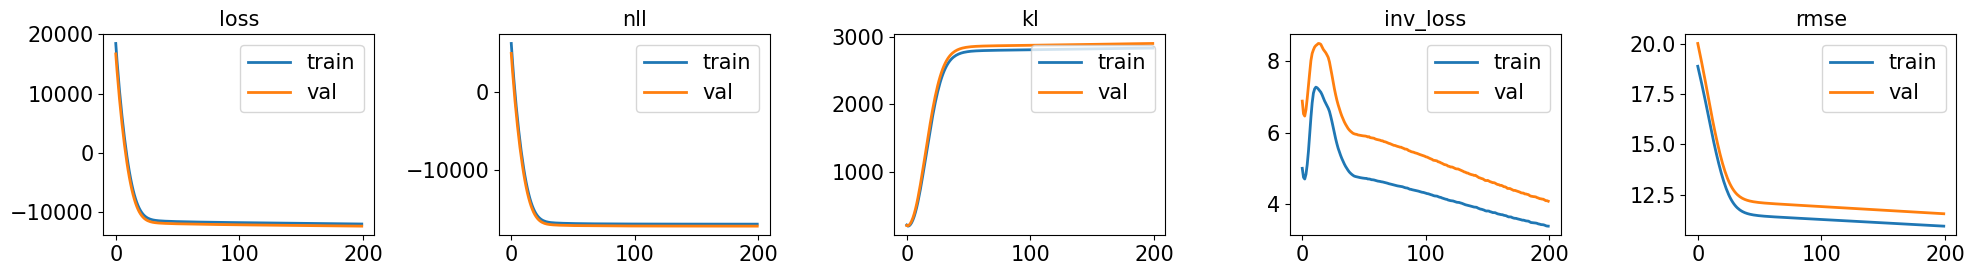

In [90]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [91]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()
x_recon = inv_model.decode(z_sample, 
                      tensor_motion.to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_denoised = inv_model.decode(z_sample, 
                      torch.zeros_like(tensor_motion).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

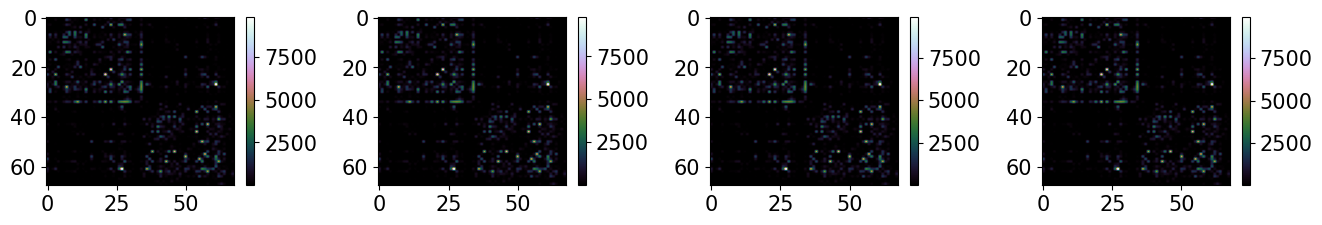

In [92]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

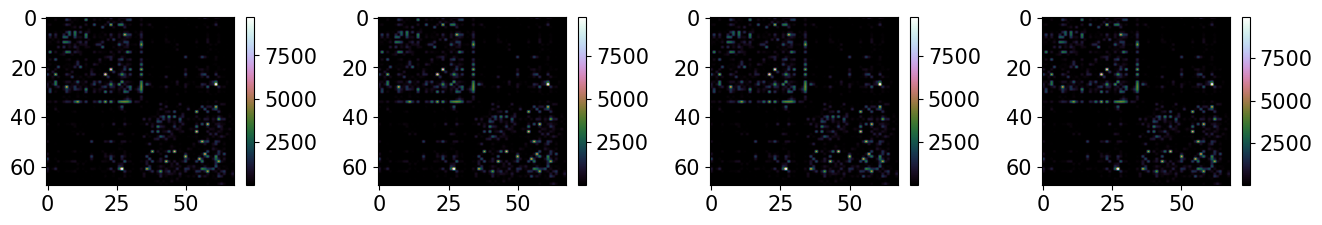

In [93]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [94]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_denoised = x_denoised[big_motion_ids]
small_motion_denoised = x_denoised[small_motion_ids]
diff_motion_denoised = big_motion_denoised.mean(0) - small_motion_denoised.mean(0)

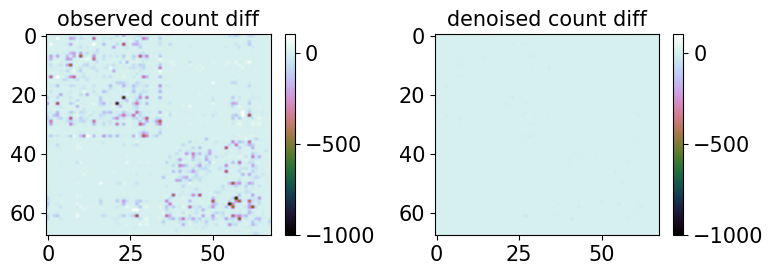

In [95]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_denoised.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('denoised count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()